In [1]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)



Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
Mon Oct 10 04:47:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P0    42W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
    

Mounted at /content/drive
Engine RUL Predictor.
Operation time (sec):  8.580240538000002
Engine units in dataset:  [1. 2. 3. 4. 5. 6.]


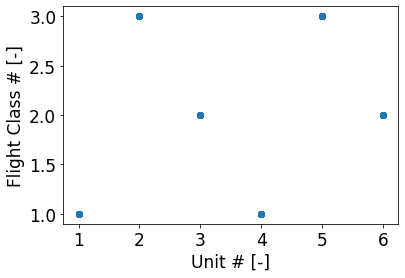

       fan_eff_mod  fan_flow_mod  LPC_eff_mod  LPC_flow_mod  HPC_eff_mod  \
count        553.0         553.0        553.0         553.0        553.0   
mean           0.0           0.0          0.0           0.0          0.0   
std            0.0           0.0          0.0           0.0          0.0   
min            0.0           0.0          0.0           0.0          0.0   
25%            0.0           0.0          0.0           0.0          0.0   
50%            0.0           0.0          0.0           0.0          0.0   
75%            0.0           0.0          0.0           0.0          0.0   
max            0.0           0.0          0.0           0.0          0.0   

       HPC_flow_mod  HPT_eff_mod  HPT_flow_mod  LPT_eff_mod  LPT_flow_mod  \
count         553.0   553.000000         553.0        553.0         553.0   
mean            0.0    -0.003811           0.0          0.0           0.0   
std             0.0     0.004065           0.0          0.0           0.0   
min    

<Figure size 432x288 with 0 Axes>

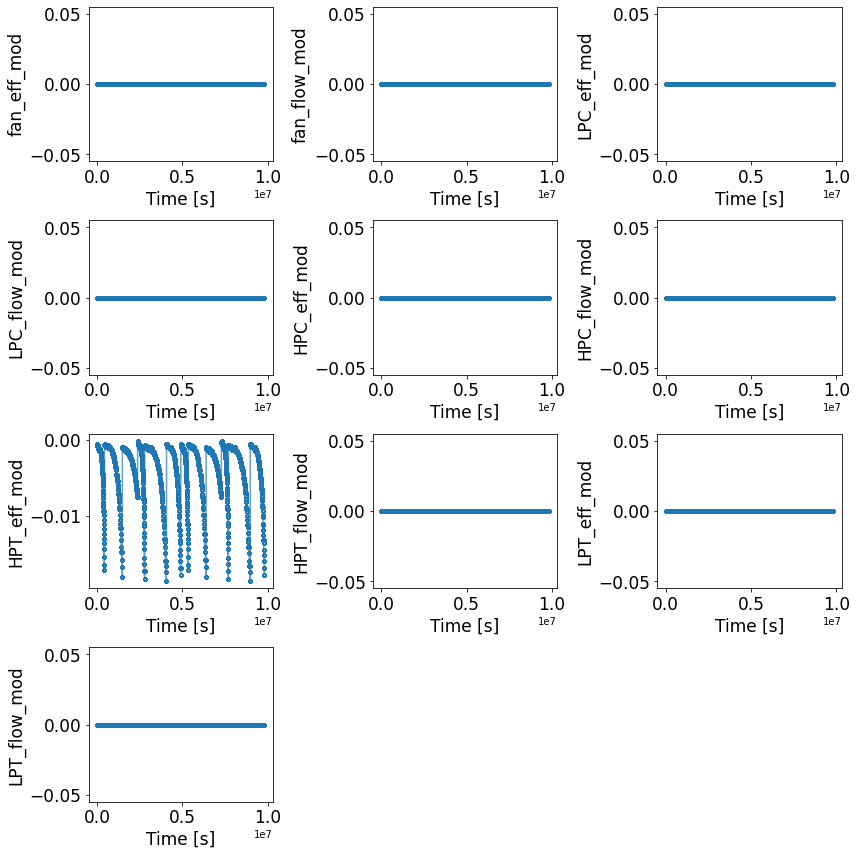

<Figure size 432x288 with 0 Axes>

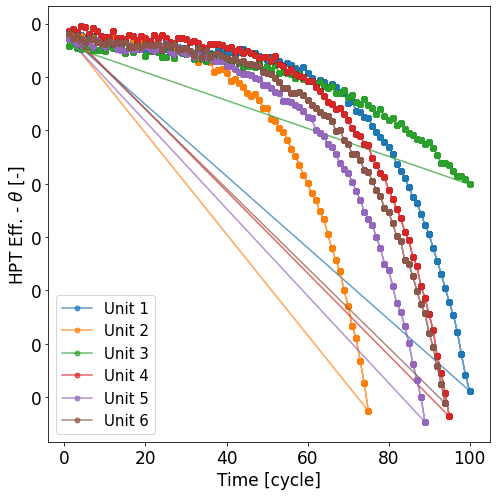

<Figure size 432x288 with 0 Axes>

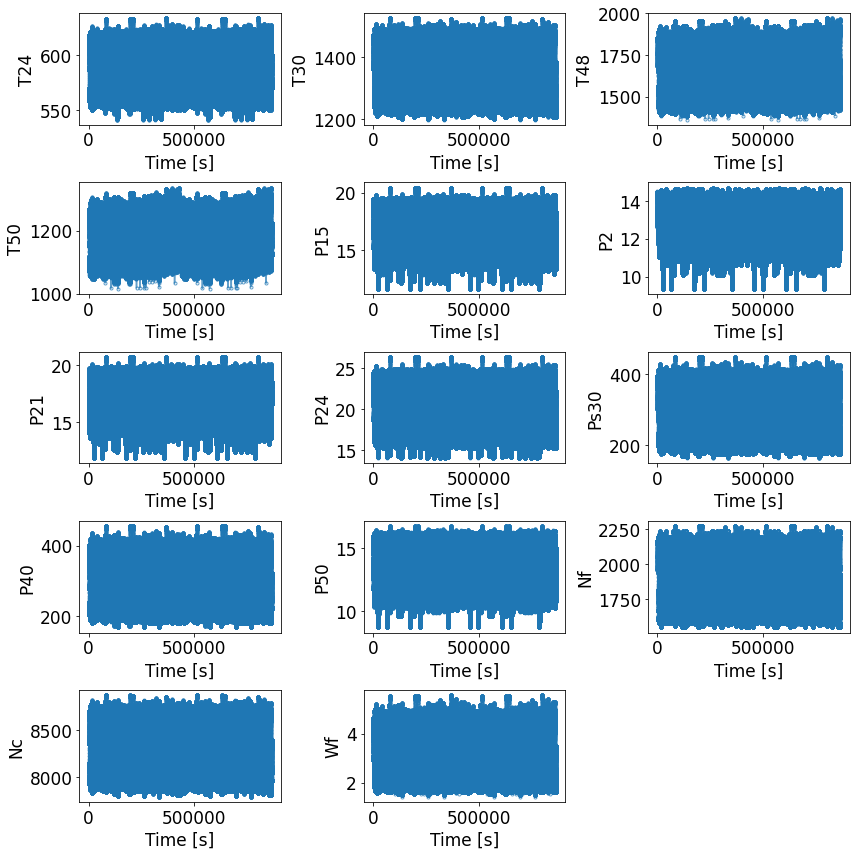

<Figure size 432x288 with 0 Axes>

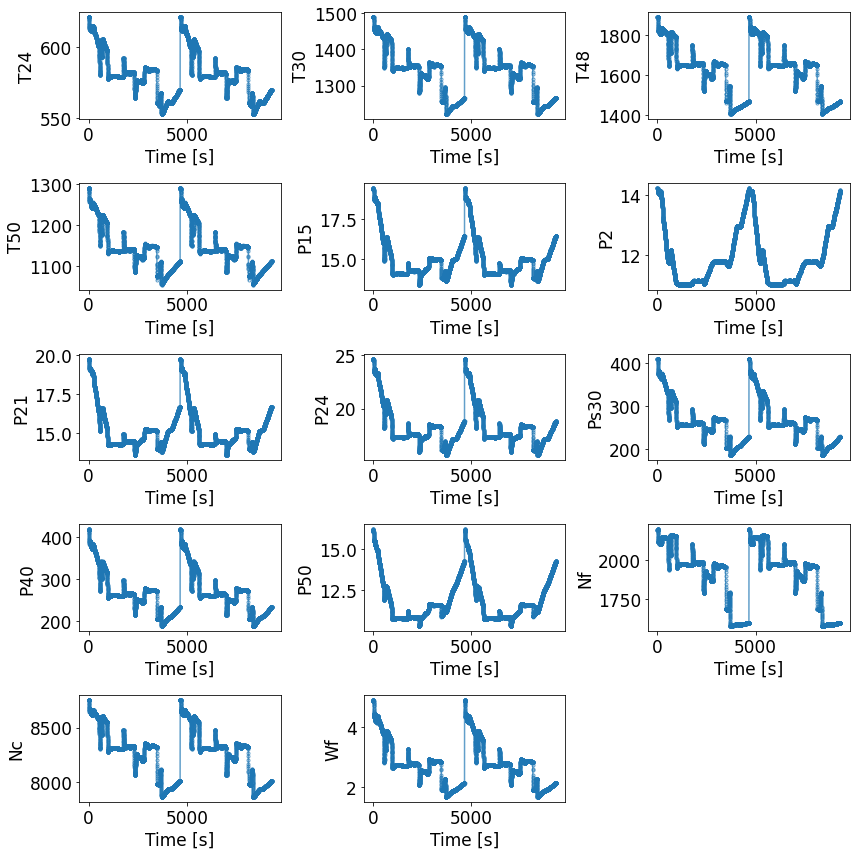

<Figure size 432x288 with 0 Axes>

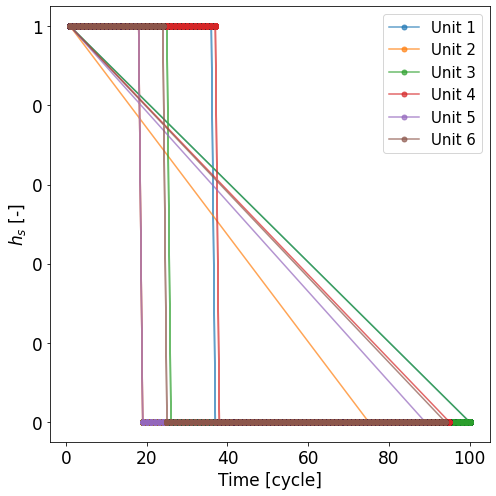

<Figure size 432x288 with 0 Axes>

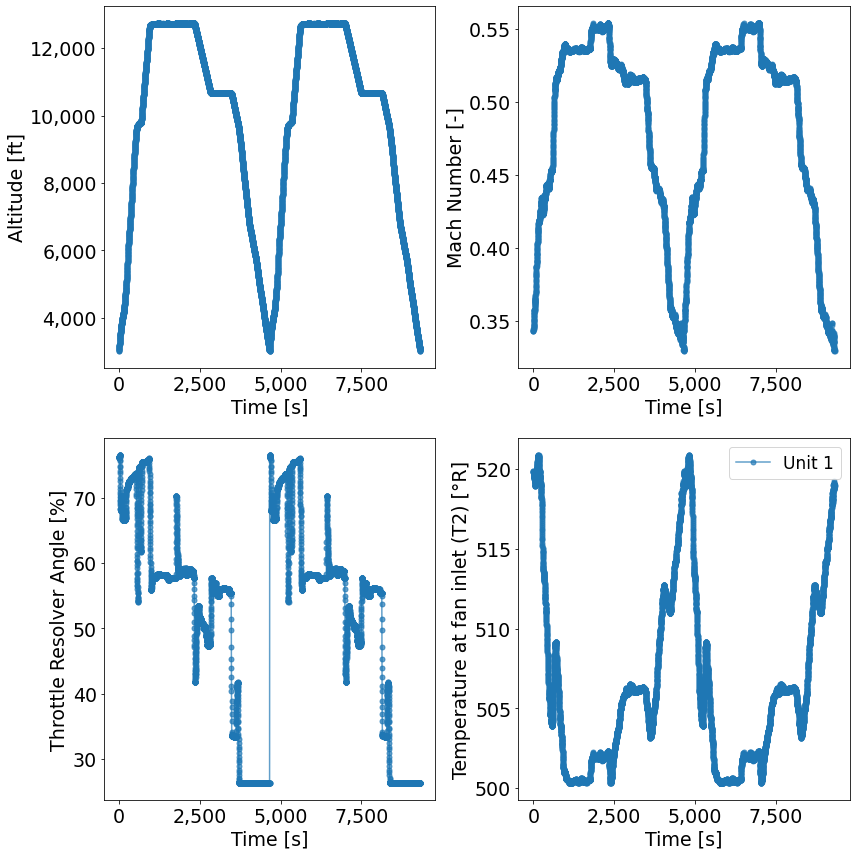

<Figure size 504x360 with 0 Axes>

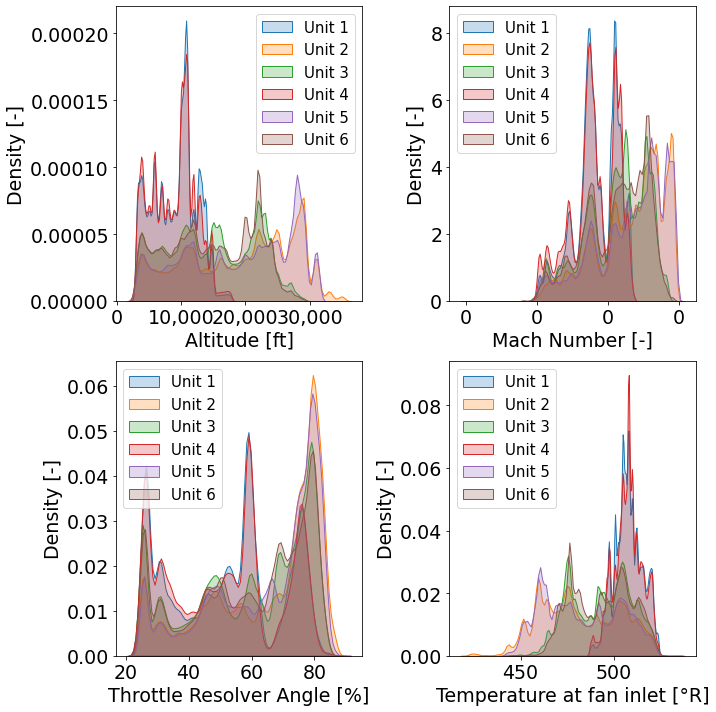

In [2]:
"""
    Project Name: PdM Model for NASA Jet Engines
    Data: 10/9/2022
    Author: Arpi Derm
    Description: This model aims to use PdM model and RUL to predict failures in point time T in near future.
                 This specific model is built and trained for the NASA's PCoE Turbofan Engine Degradation (Run-To-Failure) dataset.
    Dataset Description: 
                Dataset description along with its variable can be found in the dataset paper writtent by 
                Manuel Arias Chao,Chetan Kulkarni, Kai Goebel and Olga Fink. https://dx.doi.org/10.3390/data6010005
    Variable Name Descriptions:
            w = Scenario-descriptor operating conditions (inputs to system model)
            x_s = sensor signal measurements (physical properties)
            x_v = virtual sensor signals
            t = engine health parameters 
            y_rul = target output Y - RUL (Remaning Useful Life) of engine unit
            aux = Auxiliaryl data such as cycle count, unit id, ...
"""

import os
import h5py
import time
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from pandas import DataFrame
from matplotlib import gridspec
from google.colab import drive

drive.mount("/content/drive")

# Load all datasets
DS_001 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS01-005.h5"
DS_002 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS02-006.h5"
DS_003 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS03-012.h5"
DS_004 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS04.h5"
DS_005 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS05.h5"
DS_006 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS06.h5"
DS_007 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS07.h5"
DS_008 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08a-009.h5"
DS_009 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08c-008.h5"
DS_010 = "/content/drive/MyDrive/Predictive_Maintenence_Fault_Detection/data_set/N-CMAPSS_DS08d-010.h5"

# Params
PLOT_LBL_SIZE = 17
COLOR_DIC_UNIT = {
    "Unit 1": "C0",
    "Unit 2": "C1",
    "Unit 3": "C2",
    "Unit 4": "C3",
    "Unit 5": "C4",
    "Unit 6": "C5",
    "Unit 7": "C6",
    "Unit 8": "C7",
    "Unit 9": "C8",
    "Unit 10": "C9",
    "Unit 11": "C10",
    "Unit 12": "C11",
    "Unit 13": "C12",
    "Unit 14": "C13",
    "Unit 15": "C14",
    "Unit 16": "C15",
    "Unit 17": "C16",
    "Unit 18": "C17",
    "Unit 19": "C18",
    "Unit 20": "C19",
}


class EngineRUL:
    def __init__(self):
        print("Engine RUL Predictor.")

    def load_hdf5_to_numpy_arr(self, file_name_hdf5):
        """
        Convert HDF5 raw data to numpy array.
        The data set is already broken to development and test sets. We just need to create separate variable sets for each.
        The dev set will be used for training the model and the test set will be used for evaluating and predictions.
        """

        op_time = time.process_time()

        with h5py.File(file_name_hdf5, "r") as hdf:

            # Get the model development set
            self.w_dev = np.array(hdf.get("W_dev"))  # Scenario-descriptor operating conditions
            self.x_s_dev = np.array(hdf.get("X_s_dev"))  # sensor measurements
            self.x_v_dev = np.array(hdf.get("X_v_dev"))  # Virtual sensors
            self.t_dev = np.array(hdf.get("T_dev"))  # Engine heath parameters
            self.y_rul_dev = np.array(hdf.get("Y_dev"))  # Target output Y - RUL of engine unit
            self.aux_dev = np.array(hdf.get("A_dev"))  # Auxiliary data

            # Get the model test set
            self.w_test = np.array(hdf.get("W_dev"))  # Scenario-descriptor operating conditions
            self.x_s_test = np.array(hdf.get("X_s_dev"))  # sensor measurements
            self.x_v_test = np.array(hdf.get("X_v_dev"))  # Virtual sensors
            self.t_test = np.array(hdf.get("T_dev"))  # Engine heath parameters
            self.y_rul_test = np.array(hdf.get("Y_dev"))  # Target output Y - RUL of engine unit
            self.aux_test = np.array(hdf.get("A_dev"))  # Auxiliary data

            # Get the variable names for each type of variable in the dataset
            self.w_var_names = np.array(hdf.get("W_var"))
            self.x_s_var_names = np.array(hdf.get("X_s_var"))
            self.x_v_var_names = np.array(hdf.get("X_v_var"))
            self.t_var_names = np.array(hdf.get("T_var"))
            self.aux_var_names = np.array(hdf.get("A_var"))

            # from np.array to list dtype U4/U5
            self.w_var_names = list(np.array(self.w_var_names, dtype="U20"))
            self.x_s_var_names = list(np.array(self.x_s_var_names, dtype="U20"))
            self.x_v_var_names = list(np.array(self.x_v_var_names, dtype="U20"))
            self.t_var_names = list(np.array(self.t_var_names, dtype="U20"))
            self.aux_var_names = list(np.array(self.aux_var_names, dtype="U20"))

        # Create complete development and test set of each varaible type
        self.w = np.concatenate((self.w_dev, self.w_test), axis=0)
        self.x_s = np.concatenate((self.x_s_dev, self.x_s_test), axis=0)
        self.x_v = np.concatenate((self.x_v_dev, self.x_v_test), axis=0)
        self.t = np.concatenate((self.t_dev, self.t_test), axis=0)
        self.y_rul = np.concatenate((self.y_rul_dev, self.y_rul_test), axis=0)
        self.aux = np.concatenate((self.aux_dev, self.aux_test), axis=0)

        # Generate dataframes
        self.df_aux = DataFrame(data=self.aux, columns=self.aux_var_names)

        self.df_t = DataFrame(data=self.t, columns=self.t_var_names)
        self.df_t["unit"] = self.df_aux["unit"].values
        self.df_t["cycle"] = self.df_aux["cycle"].values
        self.df_ts = self.df_t.drop_duplicates()

        self.df_w = DataFrame(data=self.w, columns=self.w_var_names)
        self.df_w["unit"] = self.df_aux["unit"].values

        self.df_x_s = DataFrame(data=self.x_s, columns=self.x_s_var_names)
        self.df_v_s = DataFrame(data=self.x_v, columns=self.x_v_var_names)

        print("Operation time (sec): ", (time.process_time() - op_time))

    def get_engine_units_in_dataset(self):
        print("Engine units in dataset: ", np.unique(self.df_aux["unit"]))

    def plot_flight_classes(self):
        """
        Plot the engine units and their corresponding fligth class to
        findout the durations of each fligth based on the class
            Class 1 - Flight length (1-3) [h]
            Class 2 - Flight length (3-5) [h]
            Class 3 - Fligth length (5-7) [h]
        """

        plt.plot(self.df_aux.unit, self.df_aux.Fc, "o")
        plt.tick_params(axis="x", labelsize=PLOT_LBL_SIZE)
        plt.tick_params(axis="y", labelsize=PLOT_LBL_SIZE)
        plt.xlabel("Unit # [-]", fontsize=PLOT_LBL_SIZE)
        plt.ylabel("Flight Class # [-]", fontsize=PLOT_LBL_SIZE)
        plt.show()

    def show_engine_health_parameter_stats(self):
        """
        All the stats for engine degradation parameters.
        """
        print(self.df_ts.describe())

    def plot_df_single_color(self, data, variables, labels, size=12, labelsize=17, name=None):
        """
        Generic utility function to generate plots on variaus data frames for one engine in dataset
        Note: This function is taken from sample notebook provided by the dataset itself.
        """

        plt.clf()
        input_dim = len(variables)
        cols = min(np.floor(input_dim**0.5).astype(int), 4)
        rows = (np.ceil(input_dim / cols)).astype(int)
        gs = gridspec.GridSpec(rows, cols)
        fig = plt.figure(figsize=(size, max(size, rows * 2)))

        for n in range(input_dim):
            ax = fig.add_subplot(gs[n])
            ax.plot(data[variables[n]], marker=".", markerfacecolor="none", alpha=0.7)
            ax.tick_params(axis="x", labelsize=labelsize)
            ax.tick_params(axis="y", labelsize=labelsize)
            plt.ylabel(labels[n], fontsize=labelsize)
            plt.xlabel("Time [s]", fontsize=labelsize)

        plt.tight_layout()

        if name is not None:
            plt.savefig(name, format="png", dpi=300)

        plt.show()
        plt.close()

    def plot_df_color_per_unit(self, data, variables, labels, size=7, labelsize=17, option="Time", name=None):
        """
        Generic utility function to generate plots on variaus data frames overlayed in one plot
        Note: This function is taken from sample notebook provided by the dataset itself.
        """

        plt.clf()
        input_dim = len(variables)
        cols = min(np.floor(input_dim**0.5).astype(int), 4)
        rows = (np.ceil(input_dim / cols)).astype(int)
        gs = gridspec.GridSpec(rows, cols)
        leg = []
        fig = plt.figure(figsize=(size, max(size, rows * 2)))

        unit_sel = np.unique(data["unit"])
        for n in range(input_dim):
            ax = fig.add_subplot(gs[n])
            for j in unit_sel:
                data_unit = data.loc[data["unit"] == j]
                if option == "cycle":
                    time_s = data.loc[data["unit"] == j, "cycle"]
                    label_x = "Time [cycle]"
                else:
                    time_s = np.arange(len(data_unit))
                    label_x = "Time [s]"
                ax.plot(
                    time_s,
                    data_unit[variables[n]],
                    "-o",
                    color=COLOR_DIC_UNIT["Unit " + str(int(j))],
                    alpha=0.7,
                    markersize=5,
                )
                ax.tick_params(axis="x", labelsize=labelsize)
                ax.tick_params(axis="y", labelsize=labelsize)
                leg.append("Unit " + str(int(j)))
            plt.ylabel(labels[n], fontsize=labelsize)
            plt.xlabel(label_x, fontsize=labelsize)
            ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
            if n == 0:
                ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
        plt.legend(leg, loc="best", fontsize=labelsize - 2)  # lower left
        plt.tight_layout()

        if name is not None:
            plt.savefig(name, format="png", dpi=300)

        plt.show()
        plt.close()

    def plot_kde(self, leg, variables, labels, size, units, df_W, df_A, labelsize=17, name=None):
        """
        Flight conditions histogram.
        Note: This function is taken from sample notebook provided by the dataset itself.
        """

        plt.clf()
        input_dim = len(variables)
        cols = min(np.floor(input_dim**0.5).astype(int), 4)
        rows = (np.ceil(input_dim / cols)).astype(int)
        gs = gridspec.GridSpec(rows, cols)
        fig = plt.figure(figsize=(size, max(size, rows * 2)))

        for n in range(input_dim):
            ax = fig.add_subplot(gs[n])
            for k, elem in enumerate(units):
                sns.kdeplot(
                    df_W.loc[df_A["unit"] == elem, variables[n]], color=COLOR_DIC_UNIT[leg[k]], shade=True, gridsize=100
                )
                ax.tick_params(axis="x", labelsize=labelsize)
                ax.tick_params(axis="y", labelsize=labelsize)

            ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ",")))
            plt.xlabel(labels[n], fontsize=labelsize)
            plt.ylabel("Density [-]", fontsize=labelsize)
            if n == 0:
                plt.legend(leg, fontsize=labelsize - 4, loc=0)
            else:
                plt.legend(leg, fontsize=labelsize - 4, loc=2)
        plt.tight_layout()
        if name is not None:
            plt.savefig(name, format="png", dpi=300)
        plt.show()
        plt.close()

    def generate_sensor_readings_graphs_single_unit(self, engine_unit):
        """
        Generate graphs for all sensor readings on one engine unit
        """

        df_x_s_u = self.df_x_s.loc[self.df_aux.unit == engine_unit]
        df_x_s_u.reset_index(inplace=True, drop=True)
        labels = self.x_s_var_names
        self.plot_df_single_color(df_x_s_u, self.x_s_var_names, labels)

    def generate_sensor_readings_graphs_single_unit_single_cycle(self, engine_unit, cycle):
        """
        Generate graphs for all sensor readings on one engine unit at a single specified cycle
        """

        df_x_s_u_c = self.df_x_s.loc[(self.df_aux.unit == engine_unit) & (self.df_aux.cycle == cycle)]
        df_x_s_u_c.reset_index(inplace=True, drop=True)
        self.plot_df_single_color(df_x_s_u_c, self.x_s_var_names, self.x_s_var_names)

    def plot_health_states_for_all_engines(self):
        self.plot_df_color_per_unit(self.df_aux, ["hs"], [r"$h_s$ [-]"], option="cycle")

    def generate_flight_profle_single_unit_single_cycle(self, engine_unit, cycle):
        """
        Generate flight profile for one unit based on scenario-descriptor operating conditions
        """

        df_W_u = self.df_w.loc[(self.df_aux.unit == engine_unit) & (self.df_aux.cycle == cycle)]
        df_W_u.reset_index(inplace=True, drop=True)
        labels = [
            "Altitude [ft]",
            "Mach Number [-]",
            "Throttle Resolver Angle [%]",
            "Temperature at fan inlet (T2) [°R]",
        ]
        self.plot_df_color_per_unit(
            df_W_u, self.w_var_names, labels, size=12, labelsize=19, name=f"flight_profile_{engine_unit}.png"
        )

    def generate_flight_envelope(self):
        """
        Generate flight evelope for each engine class.
        Note: This function is taken from sample notebook provided by the dataset itself.
        """

        labelsize = 17
        x = np.array([0.0, 0.2, 0.4, 0.6, 0.8])
        u = np.array([1.7, 1.7, 4.0, 4.0, 4.0]) * 10000
        l = np.array([0.0, 0.0, 0.0, 0.0, 1.0]) * 10000

        plt.figure(figsize=(7, 5))
        plt.fill_between(x, l, u, alpha=0.2)

        plt.plot(
            self.df_w.loc[self.df_aux["Fc"] == 3, "Mach"], self.df_w.loc[self.df_aux["Fc"] == 3, "alt"], ".", alpha=0.9
        )
        plt.plot(
            self.df_w.loc[self.df_aux["Fc"] == 2, "Mach"], self.df_w.loc[self.df_aux["Fc"] == 2, "alt"], ".", alpha=0.9
        )
        plt.plot(
            self.df_w.loc[self.df_aux["Fc"] == 1, "Mach"], self.df_w.loc[self.df_aux["Fc"] == 1, "alt"], ".", alpha=0.9
        )

        plt.tick_params(axis="x", labelsize=labelsize)
        plt.tick_params(axis="y", labelsize=labelsize)
        plt.xlim((0.0, 0.8))
        plt.ylim((0, 40000))
        plt.xlabel("Mach Number - [-]", fontsize=labelsize)
        plt.ylabel("Flight Altitude - [ft]", fontsize=labelsize)
        plt.show()

    def generate_kde_estimations_of_flight_profile(self):
        """
        Kernel density estimations of the simulated flight envelopes given by recordings of altitude, flight Mach
        number, throttle-resolver angle (TRA) and total temperature at the fan inlet (T2).
        """

        variables = ["alt", "Mach", "TRA", "T2"]
        labels = ["Altitude [ft]", "Mach Number [-]", "Throttle Resolver Angle [%]", "Temperature at fan inlet [°R]"]
        size = 10
        units = list(np.unique(self.df_aux["unit"]))
        leg = ["Unit " + str(int(u)) for u in units]
        self.plot_kde(leg, variables, labels, size, units, self.df_w, self.df_aux, labelsize=19)

    def generate_engine_health_parameter_graphs(self):
        labels = self.t_var_names
        self.plot_df_single_color(self.df_t, self.t_var_names, labels)

    def generate_hpt_eff_over_cycles_all_engines(self):
        self.plot_df_color_per_unit(self.df_t, ["HPT_eff_mod"], [r"HPT Eff. - $\theta$ [-]"], size=7, option="cycle")


if __name__ == "__main__":

    e_rul = EngineRUL()
    e_rul.load_hdf5_to_numpy_arr(DS_001)
    e_rul.get_engine_units_in_dataset()
    e_rul.plot_flight_classes()
    e_rul.show_engine_health_parameter_stats()
    e_rul.generate_engine_health_parameter_graphs()
    e_rul.generate_hpt_eff_over_cycles_all_engines()
    e_rul.generate_sensor_readings_graphs_single_unit(1)
    e_rul.generate_sensor_readings_graphs_single_unit_single_cycle(1, 2)
    e_rul.plot_health_states_for_all_engines()
    e_rul.generate_flight_profle_single_unit_single_cycle(1, 2)
    e_rul.generate_flight_envelope()
    e_rul.generate_kde_estimations_of_flight_profile()